<a href="https://colab.research.google.com/github/eddiechn/oct-disease/blob/main/OCT_Disease_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf


# Check for TensorFlow GPU access
print(f"TensorFlow has access to the following devices:\n{tf.config.list_physical_devices()}")

# See TensorFlow version
print(f"TensorFlow version: {tf.__version__}")




gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

    except RuntimeError as e:
        print(e)

/Users/eddiechen/Desktop/Projects/oct-disease/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


TensorFlow has access to the following devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow version: 2.17.0


In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import random
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

In [4]:
main_path = "data/OCT2017 "


# val, test, train have already been split in the kaggle database

train_dir = f"{main_path}/train"
val_dir = f"{main_path}/val"
test_dir = f"{main_path}/test"


In [5]:
# paths
print(train_dir)
print(val_dir)
print(test_dir)

data/OCT2017 /train
data/OCT2017 /val
data/OCT2017 /test


In [6]:
# diseases
diseases = os.listdir(train_dir)
diseases.remove('.DS_Store')
diseases


['CNV', 'DME', 'DRUSEN', 'NORMAL']

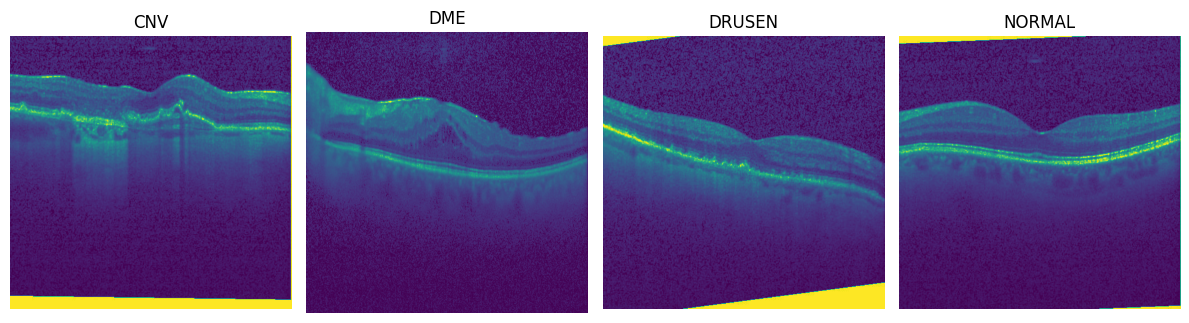

In [7]:


# Create a 2x2 subplot
fig, axs = plt.subplots(1, 4, figsize=(12, 5))

# Flatten the array of axes for easy iteration
axs = axs.flatten()

# Ensure we don't try to plot more images than available axes
for i, ax in enumerate(axs):
    if i < len(diseases):
        disease = diseases[i]
        disease_dir = os.path.join(train_dir, disease)

        # List all images in the disease directory
        images = os.listdir(disease_dir)

        # Select a random image
        img_path = os.path.join(disease_dir, np.random.choice(images))

        # Load and display the image
        img = plt.imread(img_path)
        ax.imshow(img)
        ax.set_title(disease)
        ax.axis('off')
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()

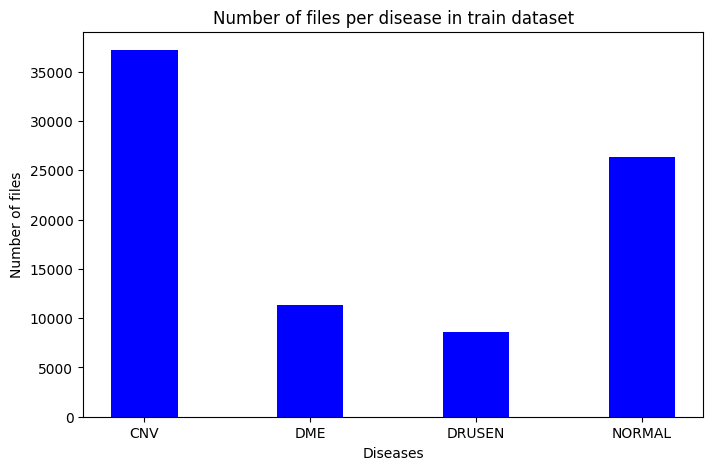

In [8]:
dataset = train_dir
image_counts = {"CNV": 0, "DME": 0, "DRUSEN": 0, "NORMAL": 0}

for disease in image_counts.keys():
    disease_dir = os.path.join(dataset, disease)
    image_counts[disease] = len(os.listdir(disease_dir))

diseases = list(image_counts.keys())
count = list(image_counts.values())

fig = plt.figure(figsize=(8,5))

plt.bar(diseases, count, color="blue", width = 0.4)

plt.xlabel("Diseases")
plt.ylabel("Number of files")
plt.title("Number of files per disease in train dataset")
plt.show()

# Training model using InceptionV3 pretrained model

In [9]:
batch_size = 32

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Activation, Dropout, Dense, Flatten, Conv2D, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D,Input,concatenate, Lambda

In [11]:
image_gen = ImageDataGenerator(rescale=1/255,
                              shear_range=0.15,
                              zoom_range=0.2,
                              horizontal_flip=True,
                               rotation_range=25,
                              )

In [19]:
train_image_gen = image_gen.flow_from_directory(train_dir,
                                                target_size=(299, 299),
                                                batch_size=batch_size,
                                                color_mode="grayscale",
                                                shuffle=True,
                                                class_mode="categorical"
                                               )

Found 83484 images belonging to 4 classes.


In [18]:
test_image_gen = image_gen.flow_from_directory(test_dir,
                                                target_size=(299, 299),
                                                batch_size=batch_size,
                                                color_mode="grayscale",
                                                shuffle=True,
                                               class_mode="categorical"
                                               )

Found 968 images belonging to 4 classes.


In [15]:
loaded_model = load_model('InceptionV3_tuning.keras')

In [16]:

# Define log directory
logdir = 'logs'

# TensorBoard callback
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

# EarlyStopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='auto',
    patience=4,
    restore_best_weights=True
)

# ModelCheckpoint callback
checkpoint = ModelCheckpoint(
    filepath='InceptionV3_tuning.keras',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='auto'
)

In [ ]:
model_results = model.fit(train_image_gen,epochs=5,
                    validation_data=test_image_gen,
                    callbacks=[tensorboard_callback, early_stopping, checkpoint])

Epoch 1/5


2024-08-09 10:24:15.356485: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
/Users/eddiechen/Desktop/Projects/oct-disease/venv/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2609/2609 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9407 - loss: 0.1804
Epoch 1: val_loss improved from inf to 0.16036, saving model to InceptionV3_tuning.keras
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 7020s 3s/step - accuracy: 0.9407 - loss: 0.1804 - val_accuracy: 0.9390 - val_loss: 0.1604
Epoch 2/5
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9468 - loss: 0.1606
Epoch 2: val_loss improved from 0.16036 to 0.05692, saving model to InceptionV3_tuning.keras
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 7306s 3s/step - accuracy: 0.9468 - loss: 0.1606 - val_accuracy: 0.9886 - val_loss: 0.0569
Epoch 3/5
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9478 - loss: 0.1536
Epoch 3: val_loss did not improve from 0.05692
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 7343s 3s/step - accuracy: 0.9478 - loss: 0.1536 - val_accuracy: 0.9370 - val_loss: 0.6258
Epoch 4/5
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9519 - loss: 0.1443
Epoch 4: val_loss improved from 0.05692 to 0.03942, saving model to Incept

####